In [ ]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.5.0


(28, 28)


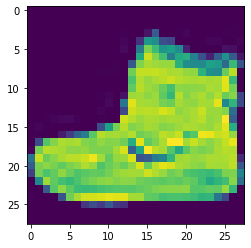

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
print(X_train[0].shape)
plt.imshow(X_train[0])

In [ ]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
print(img_shape)
noise_shape = (100,) #1D array of size 100 (latent vector / noise)
print(noise_shape)

(28, 28, 1)
(100,)


In [ ]:
##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)
    print(noise_shape)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################

In [ ]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.

In [ ]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = fashion_mnist.load_data()


    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)

#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)
        #print(imgs[0])
        #print(imgs[0].shape)
        #print(gen_imgs[0])
        #imgs.reshape(-1, 3, 32, 32)
        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/images/fashion_mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view


##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=25000, batch_size=32, save_interval=10)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.

Streaming output truncated to the last 5000 lines.
8042 [D loss: 0.673631, acc.: 62.50%] [G loss: 0.855771]
8043 [D loss: 0.636400, acc.: 65.62%] [G loss: 0.868704]
8044 [D loss: 0.697118, acc.: 43.75%] [G loss: 0.758659]
8045 [D loss: 0.716860, acc.: 62.50%] [G loss: 0.776910]
8046 [D loss: 0.615996, acc.: 59.38%] [G loss: 0.740157]
8047 [D loss: 0.742378, acc.: 46.88%] [G loss: 0.777464]
8048 [D loss: 0.648170, acc.: 71.88%] [G loss: 0.805124]
8049 [D loss: 0.714769, acc.: 40.62%] [G loss: 0.821536]
8050 [D loss: 0.671363, acc.: 62.50%] [G loss: 0.864048]
8051 [D loss: 0.720850, acc.: 50.00%] [G loss: 0.880291]
8052 [D loss: 0.657052, acc.: 68.75%] [G loss: 0.808338]
8053 [D loss: 0.700829, acc.: 43.75%] [G loss: 0.820555]
8054 [D loss: 0.704457, acc.: 53.12%] [G loss: 0.871632]
8055 [D loss: 0.742106, acc.: 43.75%] [G loss: 0.802103]
8056 [D loss: 0.624464, acc.: 62.50%] [G loss: 0.826978]
8057 [D loss: 0.648577, acc.: 68.75%] [G loss: 0.816748]
8058 [D loss: 0.702386, acc.: 59.38%]

In [6]:
ls

fashion_mnist_0.png      fashion_mnist_2150.png  fashion_mnist_6080.png
fashion_mnist_10000.png  fashion_mnist_2160.png  fashion_mnist_6090.png
fashion_mnist_1000.png   fashion_mnist_2170.png  fashion_mnist_60.png
fashion_mnist_10010.png  fashion_mnist_2180.png  fashion_mnist_6100.png
fashion_mnist_10020.png  fashion_mnist_2190.png  fashion_mnist_610.png
fashion_mnist_10030.png  fashion_mnist_2200.png  fashion_mnist_6110.png
fashion_mnist_10040.png  fashion_mnist_220.png   fashion_mnist_6120.png
fashion_mnist_10050.png  fashion_mnist_2210.png  fashion_mnist_6130.png
fashion_mnist_10060.png  fashion_mnist_2220.png  fashion_mnist_6140.png
fashion_mnist_10070.png  fashion_mnist_2230.png  fashion_mnist_6150.png
fashion_mnist_10080.png  fashion_mnist_2240.png  fashion_mnist_6160.png
fashion_mnist_10090.png  fashion_mnist_2250.png  fashion_mnist_6170.png
fashion_mnist_100.png    fashion_mnist_2260.png  fashion_mnist_6180.png
fashion_mnist_10100.png  fashion_mnist_2270.png  fashion_mnist_6190

100


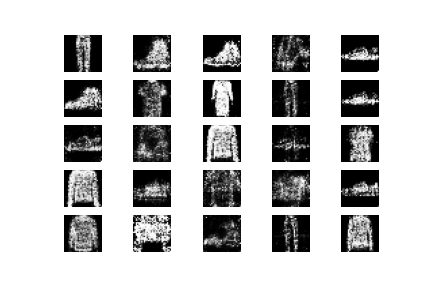

In [ ]:
from IPython.display import Image
print("100")
Image('/content/images/fashion_mnist_9990.png')

100


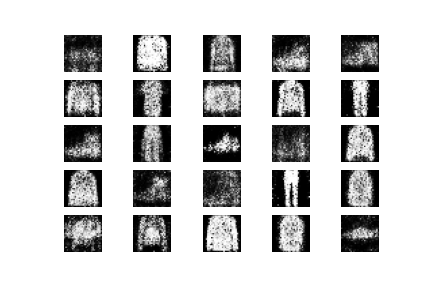

In [ ]:
from IPython.display import Image
print("100")
Image('/content/images/fashion_mnist_2490.png')